# Shinkansen Travel Experience

## Solution Team

`Julian Archer`
- [Linkedin](https://www.linkedin.com/in/archerj/)
- [Github](https://github.com/notfakearcher/julian)

`Yanjun Archer`
- [Linkedin](https://www.linkedin.com/in/yanjunarcher/)
- [Github](https://github.com/notfakearcher/yanjun)

## About

This problem statement is based on the Shinkansen Bullet Train in Japan, and passengers’ experience with that mode of travel. This machine-learning exercise aims to determine the relative importance of each parameter with regard to their contribution to the passengers’ overall travel experience. The dataset contains a random sample of individuals who travelled on this train. The on-time performance of the trains along with passenger information is published in a file named ‘Traveldata_train.csv’.  These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report labelled ‘Surveydata_train.csv’.

In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in the data of the survey report under the variable labelled ‘Overall_Experience’. 

The objective of this problem is to understand which parameters play an important role in swaying passenger feedback towards a positive scale. You are provided test data containing the travel data and the survey data of passengers. Both the test data and the train data are collected at the same time and belong to the same population.

## Problem Statement

**Goal:**\
The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.


**Dataset:**\
The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

The data has been split into two groups and provided in the Dataset folder. The folder contains both train and test data separately.

- Train_Data
- Test_Data

**Target Variable:** Overall_Experience (1 represents ‘satisfied’, and 0 represents ‘not satisfied’)

The `training set` can be used to build your machine-learning model. The training set has labels for the target column - `Overall_Experience`.

The `testing set` should be used to see how well your model performs on unseen data. For the test set, it is expected to predict the `Overall_Experience` level for each participant.

**Data Dictionary:**\
All the data is self-explanatory. The survey levels are explained in the Data Dictionary file.

**Submission File Format:** You will need to submit a CSV file with exactly 35,602 entries plus a header row. The file should have exactly two columns

- `ID`
- `Overall_Experience` (contains 0 & 1 values, 1 represents ‘Satisfied’, and 0 represents ‘Not Satisfied’)

**Evaluation Criteria:**

**Accuracy Score:** The evaluation metric is simply the percentage of predictions made by the model that turned out to be correct. This is also called the accuracy of the model. It will be calculated as the total number of correct predictions (True Positives + True Negatives) divided by the total number of observations in the dataset.
 
In other words, the best possible accuracy is 100% (or 1), and the worst possible accuracy is 0%.

## Datasets

**Train data set file**
- `Traveldata_train.csv`
- `Surveydata_train.csv`

**Test data set file**
- `Traveldata_test.csv`
- `Surveydata_test.csv`

**Sample submission file**
- `Sample_Submission.csv`

**Additional files**
- `Data_Dictionary.xlsx`

## Load Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, VotingClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import requests
from io import BytesIO
from scipy.stats import boxcox
import datetime as dt
from sklearn.decomposition import PCA
import warnings

## Global Variables

In [5]:
# Ordinal variables
vars_ordinal1 = [
  'Seat_Comfort',
  'Arrival_Time_Convenient',
  'Catering',
  'Onboard_Wifi_Service',
  'Onboard_Entertainment',
  'Online_Support',
  'Ease_of_Online_Booking',
  'Onboard_Service',
  'Legroom',
  'Baggage_Handling',
  'CheckIn_Service',
  'Cleanliness',
  'Online_Boarding'
]

vars_ordinal2 = [
  'Platform_Location'
]

# Categorical variables
vars_cat = [
  'Gender',
  'Customer_Type',
  'Type_Travel',
  'Travel_Class',
  'Seat_Class'
]

# Numerical variables
vars_number = [
  'ID',
  'Age',
  'Travel_Distance',
  'Departure_Delay_in_Mins',
  'Arrival_Delay_in_Mins',
  'Overall_Experience'
]

# Response variable
var_y = 'Overall_Experience'

# Variables to ignore
vars_exclude = [var_y] + ['ID', 'Key']

# Oridinal data dictionary
dict_ordinal1 = {
  'Extremely Poor': 0,
  'Poor': 1,
  'Needs Improvement': 2,
  'Acceptable': 3,
  'Good': 4,
  'Excellent': 5
}

dict_ordinal2 = {
  'Very Inconvenient': 0,
  'Inconvenient': 1,
  'Needs Improvement': 2,
  'Manageable': 3,
  'Convenient': 4,
  'Very Convenient': 5
}

# Random state
random_state = 4567

## User Defined Functions

In [6]:
# User defined function to check for missing values
def jra_missing_values(df):
  n = df.shape[0]
  col_names = df.columns
  col_dtype = df.dtypes
  missing_count = df.isna().sum().values
  missing_percent = np.round((missing_count / n) * 100, 0)
  df_missing = pd.DataFrame({
    'feature': col_names,
    'count': df.shape[0],
    'missing_count': missing_count,
    'missing_percent': missing_percent,
    'dtype': col_dtype
  }).sort_values(by = 'missing_count', ascending = False).reset_index(drop = 'index')
  
  return df_missing

In [7]:
# User defined function to balance data
def jra_balance_data(df, method = 'upsample'):
  
  if np.isin(method, ['upsample', 'downsample']):
    # Check label distribution
    temp = df[var_y].value_counts()
    n1 = temp.values[0]
    n2 = temp.values[1]

    if method == 'upsample':
      # Upsample minority label
      label_i = temp.index[1]
      cond = df[var_y] == label_i
      df_temp = df.loc[cond, :]
      n_diff = n1 - n2
      df_sample = resample(
        df_temp,
        replace = True,
        n_samples = n_diff,
        random_state = random_state
      )
      # Update original dataframe
      df_list = [df, df_sample]
      df = pd.concat(df_list, axis = 0, ignore_index = True)
      
    elif method == 'downsample':
      # Downsample majority label
      label_i = temp.index[0]
      cond = df[var_y] == label_i
      df_temp = df.loc[cond, :]
      n_diff = n1 - n2
      df_sample = resample(
        df_temp,
        replace = False,
        n_samples = n_diff,
        random_state = random_state
      )
      # Update original dataframe
      df = df.drop(index = df_sample.index).reset_index(drop = 'index')
      
  return df

In [41]:
# User defined function to train and validate model
def jra_train_and_validate_model(model_obj, X, y, model_name):
  
  y = y.to_numpy()
  # Split data into train and test datasets
  X_train, X_validate, y_train, y_validate = train_test_split(X, y, 
    stratify = y, shuffle = True,
    train_size = 0.8, random_state = random_state
  )
  
  # X_train = X
  # y_train = y
  # y_validate = y_train
  # X_validate = X_train
  
  # Fit model
  temp = model_obj.fit(X_train, y_train)
  
  # Get predictions on validation data
  y_hat = model_obj.predict(X_validate)

  # Model evaluation - confusion matrix

  # Get confusion matrix
  cm = confusion_matrix(
    y_true = y_validate,
    y_pred = y_hat
  )

  # Show confusion matrix visual
  labels = model_obj.classes_
  p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  p1.plot()
  plt.title('Evaluation Metric - Confusion Matrix')
  plt.show()

  # Model evaluation - recall, precision , F1-score
  metric_report = classification_report(y_true = y_validate, y_pred = y_hat, output_dict = False, zero_division = 0) 
  print(metric_report)
  
  # Model evaluation - AUC
  fig, ax = plt.subplots(figsize = (6, 6))
  RocCurveDisplay.from_predictions(ax = ax, 
    y_true = y_validate, y_pred = y_hat, pos_label = 1,
    name = model_name
  )
  plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
  plt.show()
  
  return(model_obj)

In [42]:
# User defined function to make predictions on new dataset
def jra_predict(model_obj, X, X_include):
  # Predict resposne using previously trained model
  # y_hat = model_obj.predict(pca.fit_transform(X[X_include]))
  y_hat = model_obj.predict(X[X_include])
 
  # Store results in solution template format 
  df_results = pd.DataFrame({
    'ID': X['ID'],
    var_y: y_hat
  }).astype('int')
  
  # # Save results to downloads folder
  # ts = dt.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
  # output_folder = 'C:/Users/80148956/Downloads/' # replace with your own folder
  # filename1 = output_folder + 'team_archer_submission_' + ts + '.csv'
  # df_results.to_csv(path_or_buf = filename1, header = True, index = False)
  
  return df_results

## Load Data

In [43]:
# Data dictionary - Travel Data
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Data_Dictionary.xlsx'
df_dict_travel_data = pd.read_excel(io = filename1, sheet_name = 'Travel Data', engine = 'openpyxl', skiprows = 1)
df_dict_travel_data

,Column Name,Column Description,Column Value Examples
0,ID,The unique ID of the passenger,"Continuous values like 98800001, 98800002, etc."
1,Gender,The gender of the passenger,Male\nFemale
2,Customer_Type,Loyalty type of the passenger,Loyal Customer\nDisloyal Customer
3,Age,The age of the passenger,"Continuous values like 48, 52, 9, etc."
4,Type_Travel,Purpose of travel for the passenger,Personal Travel\nBusiness Travel
5,Travel_Class,The train class that the passenger traveled in,Business\nEco
6,Travel_Distance,The distance traveled by the passenger,"Continuous values like 272, 780, 853, etc."
7,Departure_Delay_in_Mins,The delay (in minutes) in train departure,"Continuous values like 9, 15, 13, etc."
8,Arrival_Delay_in_Mins,The delay (in minutes) in train arrival,"Continuous values like 0, 15, 18, etc."


In [44]:
# Data dictionary - Survey Data
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Data_Dictionary.xlsx'
df_dict_survey_data = pd.read_excel(io = filename1, sheet_name = 'Survey Data', engine = 'openpyxl', skiprows = 1, nrows = 17)
df_dict_survey_data

,Column Name,Column Description,Column Value Examples
0,ID,The unique ID of the passenger,"Continuous values like 98800001, 98800002, etc."
1,Platform_Location,How convenient the location of the platform is...,Very Inconvenient\nInconvenient\nNeeds Improve...
2,Seat_Class,The type of the seat class in the train \nGree...,Ordinary\nGreen Car
3,Overall_Experience,The overall experience of the passenger,1 - Satisfied\n0 - Not Satisfied
4,Seat_Comfort,The comfort level of the seat for the passenger,Extremely Poor\nPoor\nNeeds Improvement\nAccep...
5,Arrival_Time_Convenient,How convenient the arrival time of the train i...,Extremely Poor\n Poor\nNeeds Improvement\nAcce...
6,Catering,How convenient the catering service is for the...,Extremely Poor\n Poor\nNeeds Improvement\nAcce...
7,Onboard_Wifi_Service,The quality of the onboard Wi-Fi service for t...,Extremely Poor\n Poor\nNeeds Improvement\nAcce...
8,Onboard_Entertainment,The quality of the onboard entertainment for t...,Extremely Poor\n Poor\nNeeds Improvement\nAcce...
9,Online_Support,The quality of the online support for the pass...,Extremely Poor\n Poor\nNeeds Improvement\nAcce...


In [45]:
# Travel Data - Train
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Traveldata_train.csv'
df_travel_data_train = pd.read_csv(filepath_or_buffer = filename1, header = 0)
df_travel_data_train.head(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


In [46]:
# Travel Data - Test
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Traveldata_test.csv'
df_travel_data_test = pd.read_csv(filepath_or_buffer = filename1, header = 0)
df_travel_data_test.head(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,99900001,Female,NaN,36.0,Business Travel,Business,532,0.0,0.0
1,99900002,Female,Disloyal Customer,21.0,Business Travel,Business,1425,9.0,28.0
2,99900003,Male,Loyal Customer,60.0,Business Travel,Business,2832,0.0,0.0
3,99900004,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0
4,99900005,Male,Disloyal Customer,18.0,Business Travel,Business,1610,17.0,0.0


In [47]:
# Survey Data - Train
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Surveydata_train.csv'
df_survey_data_train = pd.read_csv(filepath_or_buffer = filename1, header = 0)
df_survey_data_train.head(5)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [48]:
# Survey Data - Test
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Surveydata_test.csv'
df_survey_data_test = pd.read_csv(filepath_or_buffer = filename1, header = 0)
df_survey_data_test.head(5)

,ID,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Extremely Poor,Ordinary,Good,Poor,Manageable,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Acceptable,Green Car,Excellent,Acceptable,Very Convenient,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Excellent,Ordinary,Extremely Poor,Excellent,Needs Improvement,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent


In [49]:
# Sample Submissions
filename1 = 'https://github.com/notfakearcher/data/raw/main/01_shinkansen_travel_experience/Sample_Submission.csv'
df_sample_submission = pd.read_csv(filepath_or_buffer = filename1, header = 0)
df_sample_submission.head(5)

,ID,Overall_Experience
0,99900001,1
1,99900002,0
2,99900003,0
3,99900004,0
4,99900005,1


In [50]:
# All Data - Train
df_train = pd.merge(df_travel_data_train, df_survey_data_train, on = 'ID', how = 'outer')
df_train.head(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0,0,...,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0,0,...,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0,1,...,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0,0,...,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0,1,...,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [51]:
# All Data - Test
df_test = pd.merge(df_travel_data_test, df_survey_data_test, on = 'ID', how = 'outer')
df_test.head(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Female,NaN,36.0,Business Travel,Business,532,0.0,0.0,Acceptable,...,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Female,Disloyal Customer,21.0,Business Travel,Business,1425,9.0,28.0,Extremely Poor,...,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Male,Loyal Customer,60.0,Business Travel,Business,2832,0.0,0.0,Excellent,...,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0,Acceptable,...,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Male,Disloyal Customer,18.0,Business Travel,Business,1610,17.0,0.0,Excellent,...,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent


In [52]:
# All Data
dict_df = {
  'Train': df_train, 
  'Test': df_test
}
df = pd.concat(
  dict_df, axis = 0, ignore_index = False, keys = dict_df.keys()
).reset_index(level = 0).rename(columns = {'level_0': 'Key'}).reset_index(drop = 'index')

df.tail(5)

,Key,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
129976,Test,99935598,Male,Loyal Customer,8.0,Personal Travel,Eco,1334,0.0,0.0,...,Acceptable,Needs Improvement,Acceptable,Acceptable,Good,Excellent,Good,Acceptable,Good,Acceptable
129977,Test,99935599,Female,Loyal Customer,53.0,Business Travel,Business,1772,0.0,0.0,...,Acceptable,Excellent,Excellent,Good,Good,Good,Good,Acceptable,Good,Good
129978,Test,99935600,Male,Disloyal Customer,22.0,Business Travel,Eco,1180,0.0,0.0,...,Needs Improvement,Good,Poor,Needs Improvement,Poor,Acceptable,Poor,Poor,Excellent,Needs Improvement
129979,Test,99935601,Female,Loyal Customer,67.0,Personal Travel,Eco,420,23.0,16.0,...,Acceptable,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Acceptable,Excellent,Good
129980,Test,99935602,Male,NaN,20.0,Personal Travel,Eco,1680,0.0,0.0,...,Poor,Good,Poor,Poor,Acceptable,Good,Good,Needs Improvement,Good,Poor


## Exploratory Data Analysis + Data Transformations + Feature Engineering

In [53]:
# Dataset overview
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

In [54]:
# Descriptives on numerical variables
df_train.describe(include = 'number').round(2).T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,98847190.00,27245.01,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,39.42,15.12,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1978.89,1027.96,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,14.65,38.14,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,15.01,38.44,0.0,0.0,0.0,13.0,1584.0
Overall_Experience,94379.0,0.55,0.50,0.0,0.0,1.0,1.0,1.0


In [55]:
# Descriptives on object variables
df_train.describe(include = 'object').T

,count,unique,top,freq
Gender,94302,2,Female,47815
Customer_Type,85428,2,Loyal Customer,69823
Type_Travel,85153,2,Business Travel,58617
Travel_Class,94379,2,Eco,49342
Seat_Comfort,94318,6,Acceptable,21158
Seat_Class,94379,2,Green Car,47435
Arrival_Time_Convenient,85449,6,Good,19574
Catering,85638,6,Acceptable,18468
Platform_Location,94349,6,Manageable,24173
Onboard_Wifi_Service,94349,6,Good,22835


In [56]:
# Check Missing Values
jra_missing_values(df_train)

,feature,count,missing_count,missing_percent,dtype
0,Type_Travel,94379,9226,10.0,object
1,Customer_Type,94379,8951,9.0,object
2,Arrival_Time_Convenient,94379,8930,9.0,object
3,Catering,94379,8741,9.0,object
4,Onboard_Service,94379,7601,8.0,object
5,Arrival_Delay_in_Mins,94379,357,0.0,float64
6,Baggage_Handling,94379,142,0.0,object
7,Online_Support,94379,91,0.0,object
8,Legroom,94379,90,0.0,object
9,CheckIn_Service,94379,77,0.0,object


In [57]:
# Copy dataframe
df2 = df.copy(deep = True)

# Replace keys with values for ordinal values
pd.set_option('future.no_silent_downcasting', True)
df2[vars_ordinal1] = df2[vars_ordinal1].replace(dict_ordinal1).astype('object')
df2[vars_ordinal2] = df2[vars_ordinal2].replace(dict_ordinal2).astype('object')

# # Convert Departure_Delay_in_Mins and Arrival_Delay_in_Mins to categorical variables having buckets
# x_list = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
# for x in x_list:
#   df2.loc[(df2[x] <= 10), x] = 0
#   df2.loc[(df2[x] > 10) & (df2[x] <= 20), x] = 1
#   df2.loc[(df2[x] > 20) & (df2[x] <= 30), x] = 2
#   df2.loc[(df2[x] > 30), x] = 3
# df2[x_list] = df2[x_list].astype('object')

# Convert delays into average delay
warnings.filterwarnings('ignore')  
x_list = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
df2['Delay'] = np.nanmean(df2[x_list], axis = 1)
df2 = df2.drop(columns = x_list, errors = 'ignore')

# Convert Age to categorical variables having buckets of 5
# x = 'Age'
# df2[x] = df2[x] // 10
# df2[x] = df2[x].astype('object')

# One-Hot-Encoding for categorical variables
onehot = OneHotEncoder(handle_unknown = 'ignore', dtype = 'float', sparse_output = False)
# var_list = vars_cat + vars_ordinal1 + vars_ordinal2 + x_list + [x]
# var_list = vars_cat + vars_ordinal1 + vars_ordinal2 + [x]
var_list = vars_cat + vars_ordinal1 + vars_ordinal2
df_temp = pd.DataFrame(onehot.fit_transform(df2[var_list]))
df_temp.columns = onehot.get_feature_names_out()
df2 = pd.concat([df2, df_temp], axis = 1).drop(columns = var_list, errors = 'ignore')

# Remove all features with "Missing" in the name
df2 = df2.filter(regex = '^((?!nan).)*$')

# Impute Data
estimator_model = DecisionTreeRegressor(
)
imputer = IterativeImputer(
  estimator = estimator_model,
  missing_values = np.nan,
  max_iter = 5,
  verbose = 0,
  imputation_order = 'roman',
  random_state = random_state
)
# var_list = ['Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Age']
var_list = ['Travel_Distance', 'Delay', 'Age']
df2[var_list] = pd.DataFrame(imputer.fit_transform(df2[var_list]))

# Normalize all variables
norm = StandardScaler()
# norm = RobustScaler()
col_names = df2.columns
cond = ~col_names.isin(vars_exclude)
col_names = col_names[cond]
df2[col_names] = norm.fit_transform(df2[col_names])

# Train data
cond = df2['Key'] == 'Train'
df_train2 = df2.loc[cond, ].drop(columns = 'Key', errors = 'ignore')

# Balance Train data
df_train2 = jra_balance_data(df = df_train2, method = 'upsample')

# Test data
cond = df2['Key'] == 'Test'
df_test2 = df2.loc[cond, ].drop(columns = ['Key', var_y], errors = 'ignore')

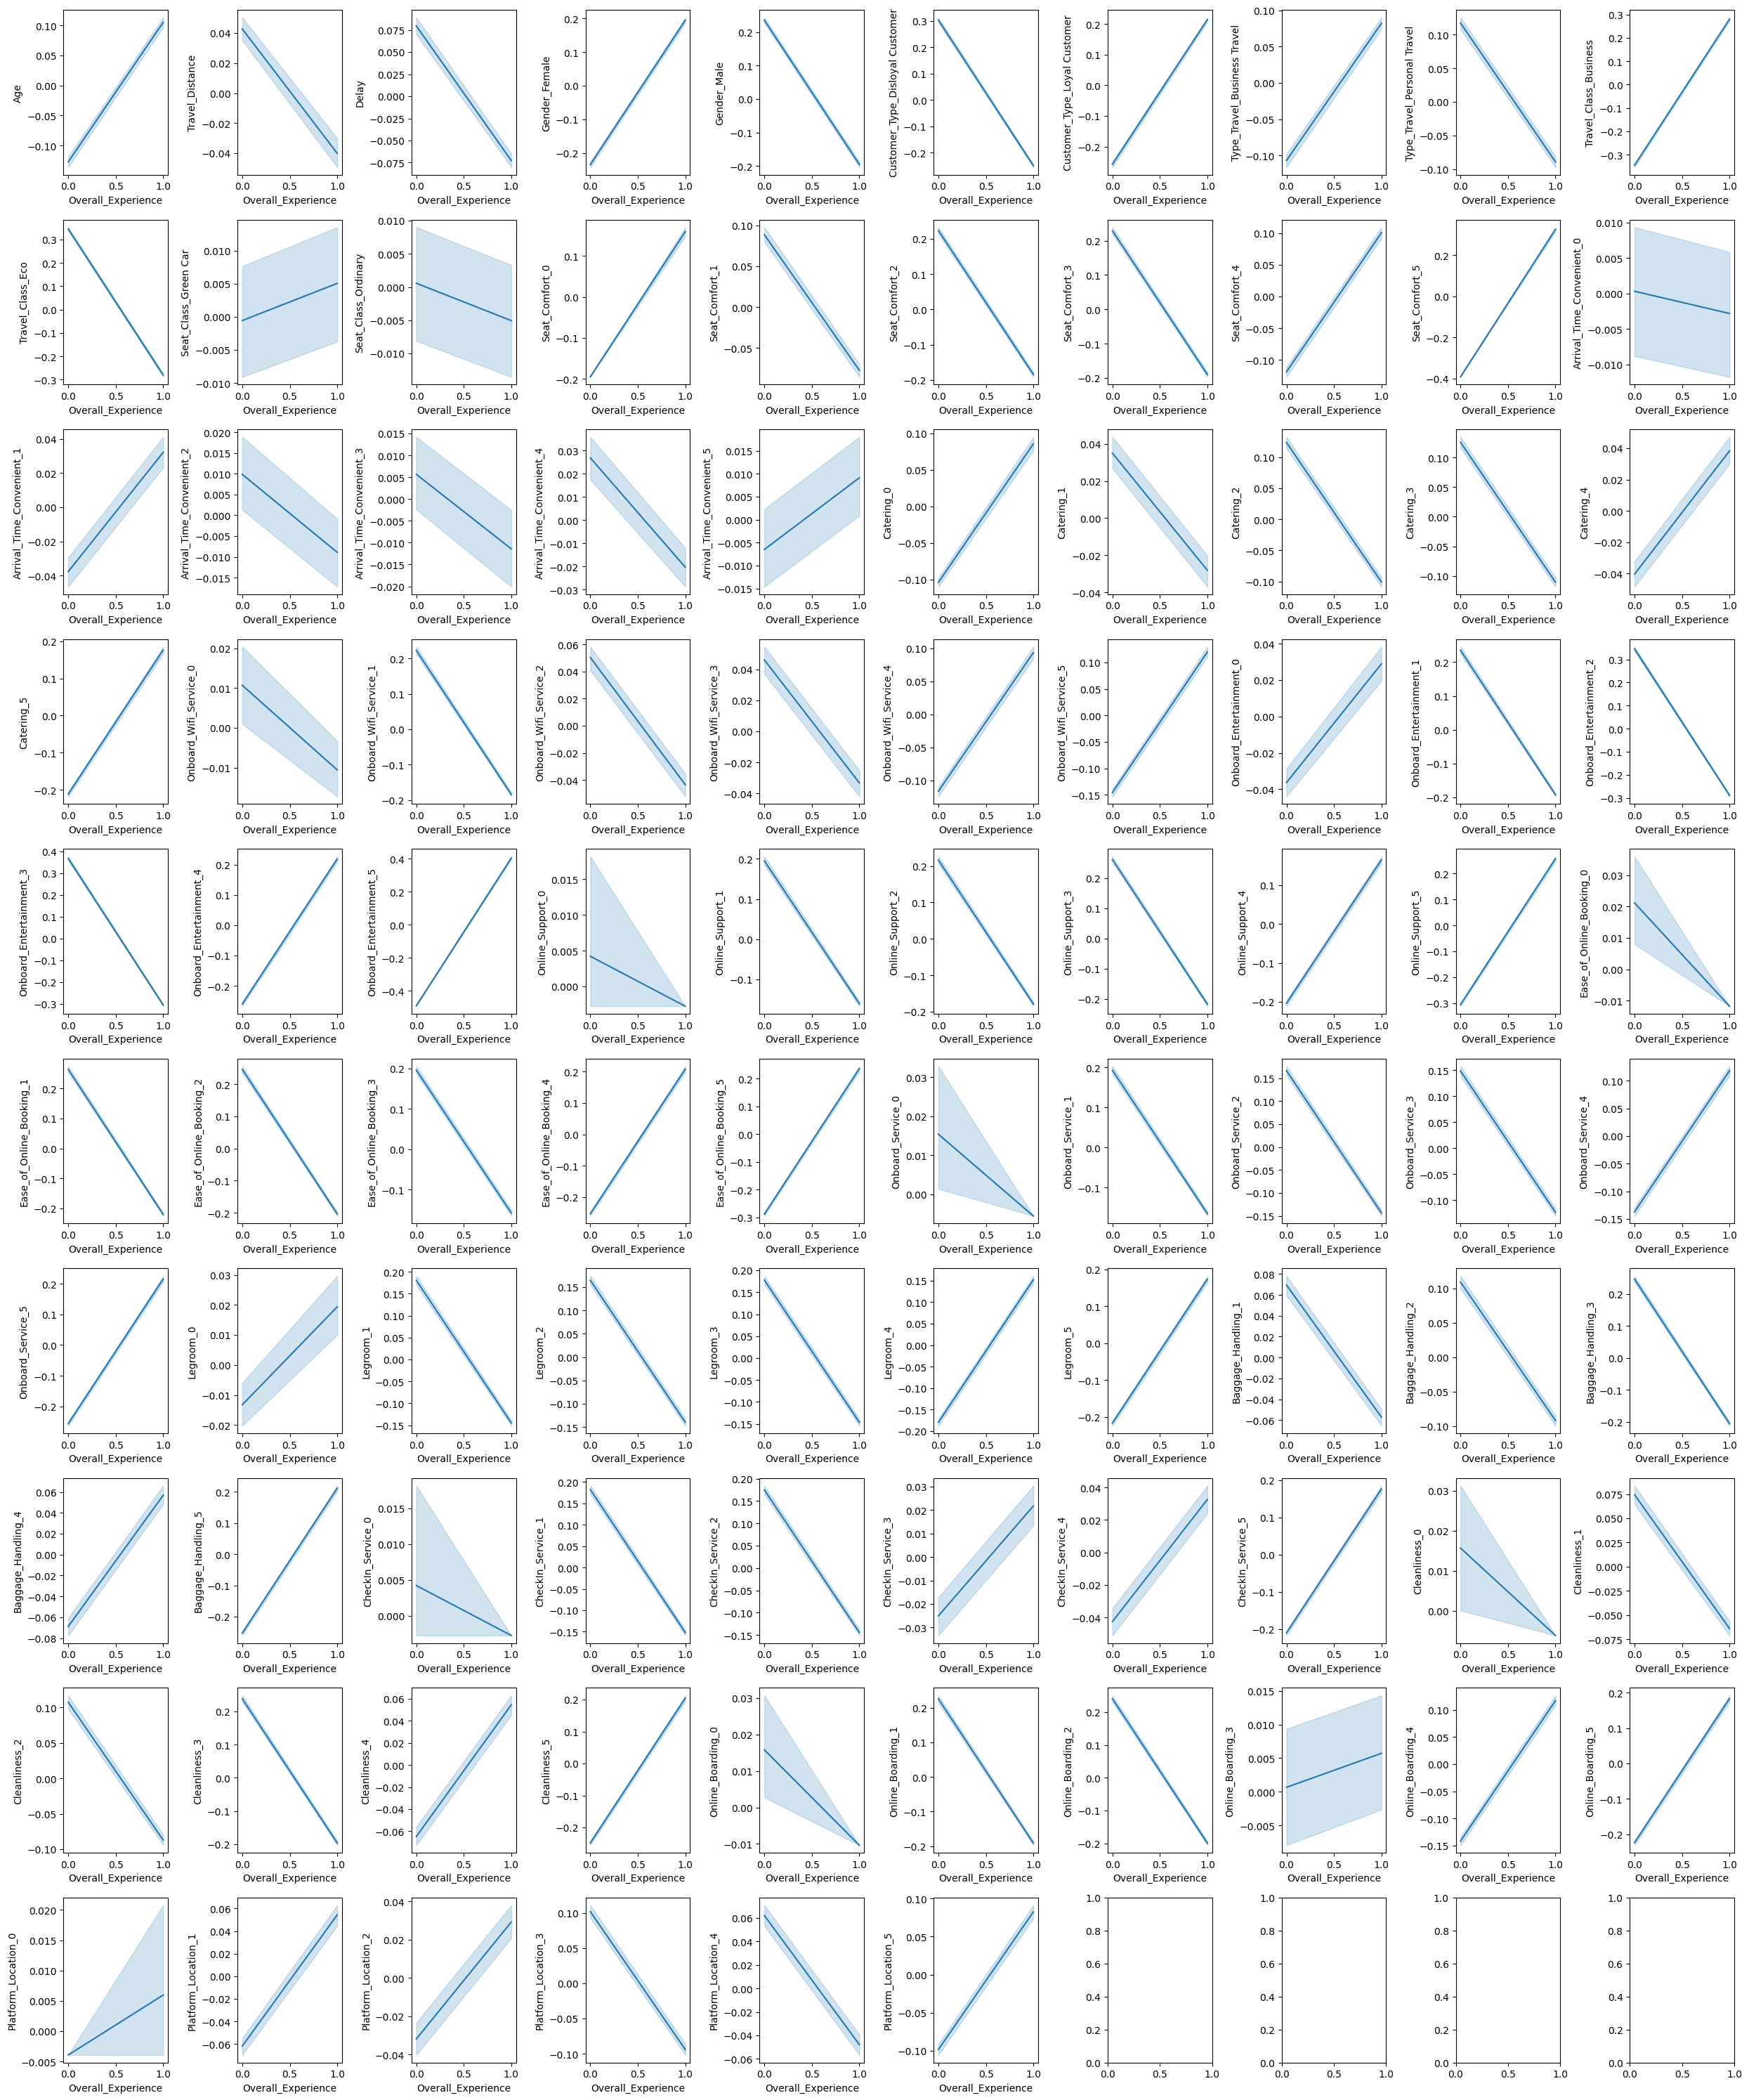

In [58]:
# Main effect plot of response vs predictors

# Predictor Variables
col_names = df_train2.columns
cond = ~col_names.isin(vars_exclude)
vars_x = col_names[cond]

# Figure setup
fig_cols = 10
fig_rows = np.ceil(len(vars_x) / fig_cols).astype('int')
y_max = np.round(df_train2[vars_x].max().max(), 0)
y_min = np.round(df_train2[vars_x].min().min(), 0)
n_levels = df_train2[var_y].unique().size
figsize = (25, 30)

# Subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
y = var_y
for x in vars_x:
  row = np.floor(itr / fig_cols)
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int')
  p1 = sns.lineplot(ax = axes[row, col], data = df_train2, x = y, y = x, estimator = 'mean', errorbar=('ci', 95))
  axes[row, col].legend_ = None
  itr += 1

plt.tight_layout()
plt.show()

## Train Classification Model

### Variables

In [59]:
# Selected predictor variabels
cond = ~df_train2.columns.isin(vars_exclude)
vars_x = df_train2.columns[cond]

# Predictor variable dataframe
X = df_train2[vars_x]

# Response variable
y = df_train2[var_y]

### Feature selection

#### No feature selection

In [60]:
# # No feature selection
# X_include = vars_x

# print(len(vars_x))
# print(len(X_include))
# print(X_include)

#### Feature selection using SelectFromModel method

In [61]:
# Estimator model
estimator_model = RandomForestClassifier(
  random_state = random_state
)

# Fit estimator model
temp = estimator_model.fit(X, y)

# Get threshold for feature importance values
feature_importance = estimator_model.feature_importances_
threshold = np.median(feature_importance)

# Initialize SelectFromModel
model_obj = SelectFromModel(
  estimator = estimator_model,
  threshold = threshold
)

# Fit SelectFromModel
temp = model_obj.fit_transform(X, y)

# Get column names of important features to keep
X_include = model_obj.get_feature_names_out()

print(len(vars_x))
print(len(X_include))
print(X_include)

96
48
['Age' 'Travel_Distance' 'Delay' 'Gender_Female' 'Gender_Male'
 'Customer_Type_Disloyal Customer' 'Customer_Type_Loyal Customer'
 'Type_Travel_Business Travel' 'Type_Travel_Personal Travel'
 'Travel_Class_Business' 'Travel_Class_Eco' 'Seat_Comfort_0'
 'Seat_Comfort_1' 'Seat_Comfort_2' 'Seat_Comfort_3' 'Seat_Comfort_4'
 'Seat_Comfort_5' 'Arrival_Time_Convenient_5' 'Catering_0' 'Catering_4'
 'Catering_5' 'Onboard_Entertainment_1' 'Onboard_Entertainment_2'
 'Onboard_Entertainment_3' 'Onboard_Entertainment_4'
 'Onboard_Entertainment_5' 'Online_Support_3' 'Online_Support_4'
 'Online_Support_5' 'Ease_of_Online_Booking_1' 'Ease_of_Online_Booking_2'
 'Ease_of_Online_Booking_4' 'Ease_of_Online_Booking_5' 'Onboard_Service_4'
 'Onboard_Service_5' 'Legroom_4' 'Legroom_5' 'Baggage_Handling_3'
 'Baggage_Handling_4' 'Baggage_Handling_5' 'CheckIn_Service_5'
 'Cleanliness_3' 'Cleanliness_4' 'Cleanliness_5' 'Online_Boarding_1'
 'Online_Boarding_5' 'Platform_Location_3' 'Platform_Location_4']


#### Final feature selection output

In [62]:
# Final dataframe given selected features
X = df_train2[X_include]

### Train and Validate Model - Random Forest

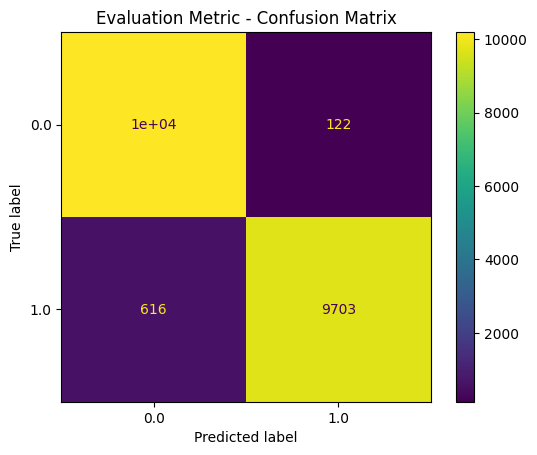

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     10319
         1.0       0.99      0.94      0.96     10319

    accuracy                           0.96     20638
   macro avg       0.97      0.96      0.96     20638
weighted avg       0.97      0.96      0.96     20638



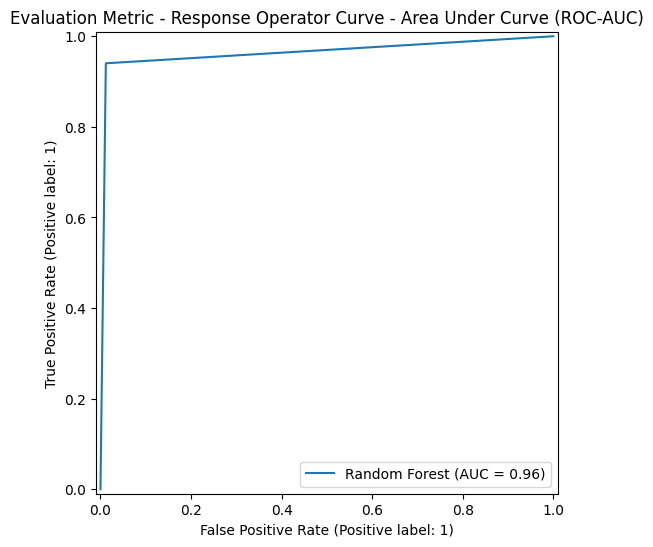

In [63]:
# Initialize model
model_obj = RandomForestClassifier(
  max_depth = 50,
  criterion = 'entropy',
  random_state = random_state
)

# Model name
model_name = 'Random Forest'

# Train and validate model
model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

## Predict on New Dataset using Classification Model

In [64]:
# Make predictions on new dataset using trained classification model
jra_predict(model_obj, df_test2, X_include)

,ID,Overall_Experience
94379,99900001,1
94380,99900002,1
94381,99900003,1
94382,99900004,0
94383,99900005,1
...,...,...
129976,99935598,0
129977,99935599,1
129978,99935600,1
129979,99935601,1


## Troubleshhooting

### Train and Validate Model - Gradinet Boosting Classifier

In [65]:
# # Initialize model
# model_obj = GradientBoostingClassifier(
#   n_estimators = 100,
#   random_state = random_state
# )

# # Model name
# model_name = 'Gradinet Boosting'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

### Train and Validate Model - Adaptive Boosting Classifier

In [66]:
# # Initialize estimtor model 
# estimator_model = RandomForestClassifier(
#   random_state = random_state
# )

# # Initialize model
# model_obj = AdaBoostClassifier(
#   algorithm = 'SAMME',
#   estimator = estimator_model, 
#   n_estimators = 1000,
#   random_state = random_state
# )

# # Model name
# model_name = 'Adaptive Boosting'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

### Train and Validate Model - Bagging Classifier

In [67]:
# # Initialize estimtor model 
# estimator_model = RandomForestClassifier(
#   random_state = random_state
# )

# # Initialize model
# model_obj = BaggingClassifier(
#   estimator = estimator_model,
#   n_estimators = 5, 
#   random_state = random_state
# )

# # Model name
# model_name = 'Bagging'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

### Train and Validate Model - Majority Voting

In [68]:
# # Classifier: Decision Tree
# dtree = (
#   'dtree',
#   DecisionTreeClassifier(
#     criterion = 'gini',
#     # min_samples_split = 10,
#     random_state = random_state
#   )
# )

# # Classifier: Random Forest
# rf = (
#   'rf',
#   RandomForestClassifier(
#     criterion = 'log_loss',
#     # min_samples_split = 10,
#     random_state = random_state
#   )
# )

# # Classifier: Bagging
# estimator_model = DecisionTreeClassifier(
#   random_state = random_state
# )
# bagging = (
#   'bagging',
#   BaggingClassifier(
#     estimator = estimator_model,
#     n_estimators = 100, 
#     random_state = random_state
#   )
# )

# # Classifier: Adaptive Boosting
# estimator_model = RandomForestClassifier(
#   random_state = random_state
# )
# adaboost = (
#   'adaboost',
#   AdaBoostClassifier(
#     algorithm = 'SAMME',
#     estimator = estimator_model, 
#     n_estimators = 100,
#     random_state = random_state
#   )
# )

In [69]:
# # Define models to be used in voting
# estimator_models = [rf, bagging]
# # estimator_models = [ptron, lr, svc, knn, nb, dtree, rf, bagging, xgboost, adaboost]
# # estimator_models = [bagging, xgboost, adaboost]
# # estimator_models = [bagging, adaboost]
# # estimator_models = [xgboost]
# # estimator_models = [rf, xgboost]
# # estimator_models = [rf, adaboost, xgboost]
# # estimator_models = [adaboost, xgboost]
# # estimator_models = [rf, adaboost]
# # estimator_models = [adaboost]
# # estimator_models = [adaboost, xgboost, dtree]
# # estimator_models = [rf, adaboost, xgboost, bagging]

In [70]:
# # Initialize estimtor model 
# estimator_model = DecisionTreeClassifier(
#   random_state = random_state
# )

# # Initialize model
# model_obj = VotingClassifier(
#   estimators = estimator_models,
#   voting = "hard"
# )

# # Model name
# model_name = 'Majority Voting'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

### Train and Validate Model - Decision Tree

In [71]:
# # Initialize model
# model_obj = DecisionTreeClassifier(
#   criterion = 'gini',
#   # min_samples_split = 10,
#   random_state = random_state
# )

# # Model name
# model_name = 'Decision Tree'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)

In [72]:
  # 'n_estimators': np.arange(5, 200 + 1, 5),
  # 'criterion': ['entropy', 'log_loss'],
#   'max_depth': np.arange(5, 50 + 1, 5),
#   'min_samples_split': np.arange(2, 20 + 1, 2),
#   'min_samples_leaf': np.arange(1, 10 + 1, 1),
#   'min_weight_fraction_leaf': np.arange(0, 1 + 0.1, 0.1),
#   'max_features': ['sqrt', 'log2', None],
#   'max_leaf_nodes': np.arange(5, 200 + 1, 5),
#   # 'bootstrap': [True, False],
#   # 'warm_start': [True, False]
# }

In [73]:
# # Initialize model
# model_obj = gridcv.best_estimator_

# # Model name
# model_name = 'Random Forest'

# # Train and validate model
# model_obj = jra_train_and_validate_model(model_obj, X, y, model_name)